In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
here = Path.cwd()
root = next(p for p in [here, *here.parents] if (p / "data" / "processed").exists())

df_v3 = pd.read_csv(root / "data" / "processed" / "merged" / "state1_clean.csv", header=0)
df_v3.head() 

,is_ios,source_file,eventType,eventSampleSpeed,eventDurationSeconds,eventMilesDriven,eventSensorDetectionMthd,eventGPSSignalStrength,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,0,android_turns.csv,5.0,12.743101,3.173500,0.007654,1,15.306123,10.714942,13.421639,3.099853,17.929585,57.610783,23.959110
1,0,android_turns.csv,5.0,11.281634,2.737719,0.008573,1,19.387754,9.529365,10.491248,1.173136,11.777087,32.709633,9.324203
2,0,android_turns.csv,5.0,11.028114,3.967555,0.009012,1,16.836735,8.478003,14.696693,2.366215,22.094933,88.539480,3.087557
3,0,android_turns.csv,4.0,19.864027,5.356430,0.025984,1,20.663265,22.033857,18.588970,2.522688,16.592813,89.536600,12.669695
4,0,android_turns.csv,5.0,16.620464,5.078434,0.019170,1,19.387754,19.640330,18.141582,2.252747,18.612541,95.261020,10.121602


In [3]:
df_v3.drop(columns=['source_file'], inplace=True)

sub_df_right = df_v3[df_v3['eventType'] == 5]
sub_df_right = sub_df_right.drop(columns=['is_ios', 'eventType', 'eventSampleSpeed', 'eventSensorDetectionMthd', 'eventGPSSignalStrength'])

In [4]:
sub_df_right.columns.tolist()

['eventDurationSeconds',
 'eventMilesDriven',
 'eventStartSpeed',
 'eventEndSpeed',
 'memsMedianHorizontalNorm',
 'gyro_angular_change_per_second',
 'gyroAngleChange',
 'mems_radius']

In [5]:
scaler =StandardScaler()

X_features = sub_df_right
features = scaler.fit_transform(X_features)
scaled_df = pd.DataFrame(features,columns=X_features.columns)

# Print the scaled data
X = scaled_df.values
scaled_df.head(2)


,eventDurationSeconds,eventMilesDriven,eventStartSpeed,eventEndSpeed,memsMedianHorizontalNorm,gyro_angular_change_per_second,gyroAngleChange,mems_radius
0,-0.856518,-0.672719,-0.513602,-0.424870,1.316534,0.831354,-0.555863,0.284335
1,-1.011310,-0.630112,-0.634383,-0.801489,-1.141357,-0.590875,-1.269141,-0.692745


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
results = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)

    sil = silhouette_score(features, labels)
    ch = calinski_harabasz_score(features, labels)

    results.append((k, sil, ch))

for r in results:
    print(f"k={r[0]} | Silhouette={r[1]:.3f} | CH Score={r[2]:.0f}")

k=2 | Silhouette=0.322 | CH Score=1041
k=3 | Silhouette=0.283 | CH Score=1093
k=4 | Silhouette=0.220 | CH Score=1008
k=5 | Silhouette=0.197 | CH Score=945
k=6 | Silhouette=0.204 | CH Score=881
k=7 | Silhouette=0.212 | CH Score=822
k=8 | Silhouette=0.188 | CH Score=791
k=9 | Silhouette=0.188 | CH Score=749


In [7]:
kmeans=KMeans(n_clusters=3)
kmeans.fit(X)
sub_df_right['cluster'] = kmeans.fit_predict(X)

In [8]:
pca=PCA(n_components=2)

reduced_X=pd.DataFrame(data=pca.fit_transform(X),columns=['PCA1','PCA2'])

#Reduced Features
reduced_X.head()

,PCA1,PCA2
0,-1.572972,-0.651825
1,-1.364746,-0.680554
2,-1.872028,0.966150
3,-0.386740,0.551550
4,-2.251671,0.854402


In [9]:
centers=pca.transform(kmeans.cluster_centers_)

# reduced centers
centers

array([[-0.94423455,  0.47622954],
       [ 1.0496435 , -1.22053205],
       [ 5.08576514,  3.15389992]])

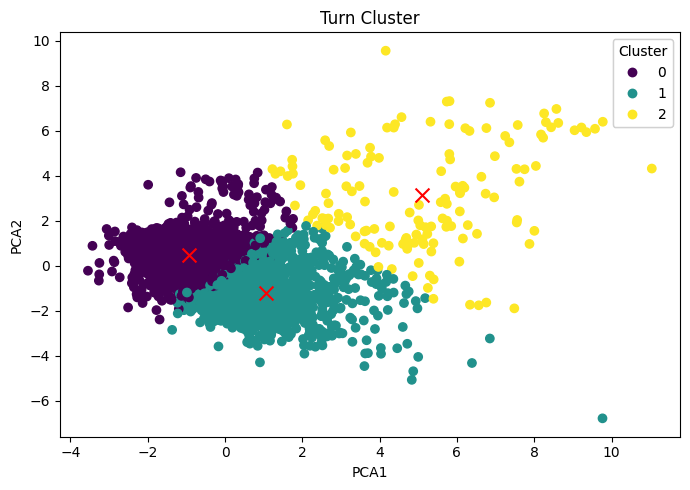

In [10]:
plt.figure(figsize=(7,5))
scatter = plt.scatter(
    reduced_X['PCA1'], reduced_X['PCA2'],
    c=kmeans.labels_, cmap='viridis'
)
plt.scatter(centers[:,0], centers[:,1], marker='x', s=100, c='red')

# Add legend showing which color corresponds to which cluster
legend = plt.legend(
    *scatter.legend_elements(),
    title="Cluster",
    loc="upper right"
)
plt.gca().add_artist(legend)

plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Turn Cluster")
plt.tight_layout()
plt.show()

In [11]:
sub_df_right.groupby('cluster').mean(numeric_only=True).T

cluster,0,1,2
eventDurationSeconds,4.921885,5.551298,15.530872
eventMilesDriven,0.014396,0.026679,0.098103
eventStartSpeed,11.760261,21.527072,26.289281
eventEndSpeed,13.100355,22.114617,25.050310
memsMedianHorizontalNorm,2.142134,2.025497,1.334539
gyro_angular_change_per_second,16.809886,10.387916,10.857430
gyroAngleChange,81.573552,57.595686,171.253647
mems_radius,12.643374,32.009382,20.768329
